# Tagging genes with ddlite: learning and labeling function iteration

## Introduction
In this example **ddlite** app, we'll build a gene tagger from scratch. Domain-specific tagging systems take months or years to develop. They use hand-crafted model circuitry and accurate, hand-labeled training data. We'll start to build a pretty good one in a few minutes with none of those things. The generalized extraction and learning utilities provided by ddlite will allow us to turn a sampling of article abstracts and some basic domain knowledge into an automated tagging system. Specifically, we want an accurate tagger for genes in academic articles. We have comprehensive dictionaries of genes, but applying a simple matching rule might yield a lot of false positives. For example, "p53" might get tagged as a gene if it refers to a page number. Our goal is to use distant supervision to improve precision.

Here's the pipeline we'll follow:

1. Obtain and parse input data (relevant article abstracts from PubMed)
2. Extract candidates for tagging
3. Generate features
4. Create a test set
5. Write labeling functions
6. Learn the tagging model
7. Iterate on labeling functions

Parts 3 through 7 are covered in this notebook. It requires candidates extracted from `GeneTaggerExample_Extraction.ipynb`, which covers parts 1 and 2.

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import cPickle
import numpy as np
import matplotlib
# print(os.environ['SNORKELDB'])
# Use production DB
from set_env import set_env
set_env() 
sys.path.insert(1, '../snorkel')

# Must set SNORKELDB before importing SnorkelSession
from snorkel import SnorkelSession
from snorkel.parser import TextDocPreprocessor
from snorkel.parser import CorpusParser
from snorkel.models import Document, Sentence, candidate_subclass
from snorkel.viewer import SentenceNgramViewer
session = SnorkelSession()

#np.random.seed(seed=1701)

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

Using postgres 104.197.203.53


## Loading candidate extractions
First, we'll load in the candidates that we created in the last notebook. We can construct an docs object with the file.

In [2]:
PhenoPair = candidate_subclass('ComplexPhenotypes', ['descriptor', 'entity'])

docs = session.query(PhenoPair).filter(PhenoPair.split == 3).all()  #should edit split to be 1. 

print "Documents:", session.query(Document).count()
print "Sentences:", session.query(Sentence).count()

##Once we get all the labels, for loop through all docs and split into train, dev, test. 

print 'Document set:\t{0} candidates'.format(len(docs))

Documents: 400
Sentences: 95656
Document set:	49042 candidates


In [3]:
from snorkel.models.context import TemporaryContext
import re

# print docs

## Make Labeling Functions

# @Jeff do not run these next 3 cells until, below you will see two more notes about where to stop and start 

In [7]:
import re
import os
from snorkel.lf_helpers import (
    get_left_tokens,
    get_between_tokens,
    get_right_tokens,
    contains_token,
    get_text_between,
    get_text_splits,
    get_tagged_text,
    is_inverted,
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
    
)


def LF_mutant(c):
    return 1 if ('mutant' in get_right_tokens(c, attrib='lemmas')) or ('mutant' in get_left_tokens(c, attrib='lemmas')) else 0
def LF_variant(c):
    return 1 if ('variant' in get_right_tokens(c, attrib='lemmas')) or ('variant' in get_left_tokens(c, attrib='lemmas')) else 0
def LF_express(c):
    return 1 if ('express' in get_right_tokens(c, attrib='lemmas')) or ('express' in get_left_tokens(c, attrib='lemmas')) else 0  
def LF_JJ(c):
    return 1 if 'JJ' in get_right_tokens(c, attrib='pos_tags') else 0
def LF_IN(c):
    return 1 if 'IN' in get_right_tokens(c, window=1, attrib='pos_tags') else 0
def LF_dna(c):
    return -1 if contains_token(c, 'DNA', attrib='words') else 0
def LF_rna(c):
    return -1 if contains_token(c, 'RNA', attrib='words') else 0
def LF_snp(c):
    return -1 if contains_token(c, 'SNP', attrib='words') else 0
def LF_protein(c):
    return -1 if 'protein' in get_left_tokens(c, attrib='lemmas') else 0
def LF_LRB(c):
    return -1 if '-LRB-' in get_right_tokens(c, window=1, attrib='pos_tags') else 0
def LF_RRB(c):
    return -1 if '-RRB-' in get_right_tokens(c, window=1, attrib='pos_tags') else 0    
def LF_NNP(c):
    return -1 if contains_token(c, 'NNP', attrib='pos_tags') else 0
def lfdistBtw0(c):
    return 1 if len(get_between_tokens(c, attrib="words")) == 0 else 0
def lfdistBtw(c):
    return 1 if len(get_between_tokens(c, attrib="words")) < 3 else 0
def lfdistBtwNeg(c):
    return -1 if len(get_between_tokens(c, attrib="words")) > 4 else 0
def lfdistBtwNeg2(c):
    return -1 if len(get_between_tokens(c, attrib="words")) > 8 else 0

action_link_words = set(['affect', 'lead', 'led', 'show', 'display', 'exhibit', 'cause', 'result in'])
mutant_words = set(['mutant', 'mutation', 'plant', 'line', 'phenotype', 'seedlings', 'variant'])
helper_vbs = set(['is', 'was', 'are', 'were', 'become', 'became'])
tester_words = set(['sequence', 'published', 'diagram', 'hypothesis', 'hypothesize', 'aim', 'goal', 'understand', 'examine', 'we', 'our', 'experiment', 'test', 'study', 'design', 'analyze', 'analysis', 'results', 'research'])
neg_words = set(['strategy', 'public', 'examine', 'measure', 'subject', 'statistic', 'instance'])

def lfnegWords(c):
    for word in neg_words:
        if contains_token(c, word, attrib='lemmas'): return -1
    return 0    

def resultsAlone(c):
    return -1 if (len(c[0].get_attrib_tokens('words')) == 1 and contains_token(c[0], 'result', attrib='lemmas')) or (len(c[1].get_attrib_tokens('lemmas')) == 1 and contains_token(c[1], 'result', attrib='lemmas')) else 0

def lfLenCand(c):
    return -1 if len(c[0].get_attrib_tokens('words')) == 1 or len(c[1].get_attrib_tokens('words')) == 1 else 0

def lf1(c):
    return 1 if 'in' in get_between_tokens(c, attrib='words') else 0

def lf2(c):
    return 1 if len(action_link_words.intersection(set(get_between_tokens(c, attrib='lemmas')))) > 0 else 0

def lf2a(c):
    for aw in action_link_words:
        if contains_token(c[1], aw, attrib='lemmas'): return 1
    return 0

def lf3(c):
    return 1 if contains_token(c[0], 'JJR', attrib='pos_tags') else 0

def lf4(c):
    return 1 if contains_token(c, r'fold') or contains_token(c, r'\d+(\.\d+_)?%') or contains_token(c, 'percent') else 0

def lf5(c):
    return 1 if len(mutant_words.intersection(set(get_left_tokens(c, attrib='lemmas')))) > 0 or len(mutant_words.intersection(set(get_right_tokens(c, attrib='lemmas')))) > 0 else 0

def lf6(c):
    return 1 if len(helper_vbs.intersection(set(get_between_tokens(c, attrib='lemmas', n_max=3)))) > 0 else 0

def lf7(c):
    return -1 if 'not' in get_between_tokens(c) else 0

def lf8(c):
    return -1 if 'not' in get_left_tokens(c[0]) or 'not' in get_left_tokens(c[1]) else 0

def lf9(c):
    return -1 if 'level' in get_left_tokens(c[0], attrib='lemmas', n_max=2) or 'level' in get_right_tokens(c[0], attrib='lemmas', n_max=2) else 0

def lf10(c):
    return -1 if 'transcript' in get_left_tokens(c[0], attrib='lemmas', n_max=3) or 'transcript' in get_right_tokens(c[0], attrib='lemmas', n_max=2) else 0

def lf11(c):
    return -1 if not contains_token(c, 'JJR', attrib='pos_tags') and not contains_token(c, 'JJ', attrib='pos_tags') and not contains_token(c[1], 'VBN', attrib='pos_tags') else 0

def inverted(c):
    return 1 if is_inverted(c) else 0

def lf12(c):
    return 1 if inverted(c) and lf1(c) else 0

def lf13(c):
    return 1 if inverted(c) and 'IN' in get_between_tokens(c, attrib='pos_tags', n_max=4) else 0

def lf14(c):
    return 1 if contains_token(c, 'phenotype', attrib='lemmas') else 0

def lf15(c):
    return -1 if 'protein' in get_left_tokens(c[0], attrib='lemmas') or 'protein' in get_right_tokens(c[0], attrib='lemmas') else 0

def lf16(c):
    return -1 if 'activity' in get_left_tokens(c[0], attrib='lemmas', n_max=2) or 'level' in get_right_tokens(c[0], attrib='lemmas', n_max=1) else 0

def lf17(c):
    return -1 if len(tester_words.intersection(set(get_tagged_text(c).split()))) > 0 else 0

# def LF_gene_dp(c):
#     return 1 if 'gene' in get_left_tokens(c[0], window=2, attrib='lemmas') else 0
# def LF_genotype_dp(c):
#     return 1 if 'genotype' in get_left_tokens(c[0], window=2, attrib='lemmas') else 0
def LF_phenotype_dp(c):
    return 1 if 'phenotype' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def LF_mutation(c):
    return 1 if ('mutation' in get_right_tokens(c[0], window=2, attrib='lemmas') or 'mutant' in get_right_tokens(c[0], window=2, attrib='lemmas') or 'mutations' in get_right_tokens(c[0], window=2, attrib='lemmas')) else 0

def LF_pheno(c):
    return 1 if contains_token(c, 'phenotype', attrib='words') else 0

def LF_dev_dp(c):
    return -1 if 'development' in get_right_tokens(c[1], window=2, attrib='lemmas')  else 0
def LF_protein_dp(c):
    return -1 if 'protein' in get_left_tokens(c[1], window=2, attrib='lemmas') or 'protein' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def LF_network_dp(c):
    return -1 if 'network' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def LF_JJ_dp(c):
    return -1 if 'JJ' in get_right_tokens(c[1], window=2, attrib='pos_tags') else 0

def lf_helpers(c):
    return 1 if any(word in get_left_tokens(c, window=2, attrib='words') for word in ['had', 'has', 'was', 'have', 'showed', 'were', 'is', 'are', 'results']) else 0

adj_words = set(['increase', 'lower', 'reduce', 'higher', 'less', 'more', 'elevate', 'decrease', 'insensitive', 'absence', 'inhibit', 'double',])
def lf_adjwords(c):
    for aw in adj_words:
        if contains_token(c, aw, attrib='lemmas'): return 1
    return 0
    
stats_words = set(['statistically', 'significant', 'quantitative', 'real-time', 'generated', 'exposed', 'stratified'])
def lf_statswords(c):
    for aw in stats_words:
        if contains_token(c, aw, attrib='lemmas'): return -1
    return 0
   
def lf_proteinIn(c):
    return -1 if 'protein' in get_left_tokens(c[1], attrib='lemmas') or 'protein' in get_right_tokens(c[1], attrib='lemmas') or contains_token(c[1], 'protein', attrib='lemmas') else 0

def lf18(c):
    return 1 if 'mutant' in get_tagged_text(c).split() or 'mutation' in get_text_splits(c) else 0

# def lf19(c):
#     lemmas = c[0].get_attrib_tokens('lemmas')
#     poses = c[0].get_attrib_tokens('pos_tags')
#     for i, w in enumerate(poses):
#         if w in ['NN', 'NNS', 'NNP', 'NNPS'] and not re.match(r'\w+(ion|ment|vity)', lemmas[i]):
#             return -1
#     return 0

def lf20(c):
    lemmas = c[0].get_attrib_tokens('lemmas')
    poses = c[0].get_attrib_tokens('pos_tags')
    result = 0
    for i, w in enumerate(lemmas):
        if w in ['NN', 'NNS', 'NNP', 'NNPS'] and not re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            result = 0
        elif re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            result = -1
    return result

def lf21(c):
    return rule_regex_search_btw_BA(c, '.* in .*', 1)

def lf22(c):
    return -1 if 'expression' in get_right_tokens(c[0], attrib='lemmas', window=2) or 'expression' in get_left_tokens(c[0], attrib='lemmas', window=2) else 0
    
def lf23(c):
    return -1 if not inverted(c) and len(helper_vbs.intersection(set(get_right_tokens(c[0], window = 1, attrib='lemmas')))) > 0 and ('VBN' == c[0].get_attrib_tokens('pos_tags')[0] or ('VBN' == c[0].get_attrib_tokens('pos_tags')[1] and 'RB' == c[0].get_attrib_tokens('pos_tags')[0])) else 0

def lf24(c):
    return -1 if not contains_token(c[0], 'VB', attrib='pos_tags') and not contains_token(c[0], 'VBZ', attrib='pos_tags') and not contains_token(c[0], 'VBD', attrib='pos_tags') else 0

def lf25(c):
    return -1 if 'IN' == c[0].get_attrib_tokens('pos_tags')[0] or 'TO' == c[0].get_attrib_tokens('pos_tags')[0] else 0

def lf26(c):
    if len(c[0].get_attrib_tokens('pos_tags')) < 2:
        return 0
    return -1 if 'JJR' == c[0].get_attrib_tokens('pos_tags')[0] and len(set(['NN', 'NNS', 'NNP', 'NNPS']).intersection(set(c[0].get_attrib_tokens('pos_tags')[1]))) == 0 else 0

def lf27(c):
    hasNoNoun = len(set(['NN', 'NNS', 'NNP', 'NNPS']).intersection(set(c[0].get_attrib_tokens('pos_tags')[0]))) == 0
    return -1 if (len(c[0]) < 3 and hasNoNoun) else 0
                  
def lf28(c):
    if len(c[0].get_attrib_tokens('pos_tags')) == 0:
        return 0
    if len(c[0].get_attrib_tokens('lemmas')) < 2:
        return 0
    lastWordAdj = True if c[0].get_attrib_tokens('pos_tags')[-1] in set(['JJ', 'JJR']) else False
    nextLastVrb = True if c[0].get_attrib_tokens('lemmas')[-2] in helper_vbs else False
    return -1 if not nextLastVrb and lastWordAdj else 0              
    
def lf29(c):                  #if pheno ends in VBG, its bad
    return -1 if c[0].get_attrib_tokens('pos_tags')[-1] == 'VBG' else 0

def lf30(c):                #if ends in prep, its bad
    return -1 if c[0].get_attrib_tokens('pos_tags')[-1] == 'IN' else 0

def lf29b(c):                  #if pheno ends in VBG, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] == 'VBG' else 0

def lf30b(c):                #if ends in prep, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] == 'IN' else 0

def lf30c(c):                  #if pheno ends in VBG, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] in ['JJ', 'JJR', 'JJS'] else 0



def lf31(c):
    return 1 if len(get_between_tokens(c, attrib='words')) <= 2 else 0

def lf32(c):
     return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['is', 'are']]) else 0
        
def lf33(c):
    return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['results', 'affected']]) else 0

def lf34(c):
    return -1 if len(get_between_tokens(c, attrib='words')) >= 5 else 0

def lf35(c):
    return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['showed', 'were',]]) else 0


In [ ]:
import csv
import os
import util
import re
from obo_parser import parseGOOBO
if 'CI' not in os.environ:
    try:
        from nltk.stem.porter import PorterStemmer
    except ImportError:
        warnings.warn("nltk not installed- some default functionality may be absent.")
        
        
def stem(w):
        """Apply stemmer, handling encoding errors"""
        stemmer = PorterStemmer()
        try:
            return stemmer.stem(w)
        except UnicodeDecodeError:
            return w

BLACKLIST = "dicts/blacklist_words.txt"

PHENO_LIST = "dicts/list_phenotypes_arabidopsis_filtered.txt"
PHENO_EQ_LIST = "dicts/phenotypes_all_eq_dict.txt"
PHENO_MANUAL = "dicts/phenotypes_manual.txt"
ONTOLOGIES = ["dicts/po.obo", "dicts/chebi.obo", "dicts/go-basic.obo"]
PATO_ONTOLOGY = "dicts/pato.obo"


def read_blacklist():
    """
    Read the blacklist words from disk.
    """
    with open(BLACKLIST) as blacklist:
        # Blacklist words are in the second column, starting on the second row.
        return [line.rstrip().split('\t')[1].lower() for line in blacklist][1:]

def load_pheno_list():
    """
    Loads a list of phenotypes from multiple files.
    """
    result = []
    result.extend(util.read_file_lines(PHENO_LIST))
    split = []
    for r in result:
        split.extend(r.split(r'[\.,;]'))
    result.extend(split)
    result.extend(util.read_tsv_flat(PHENO_EQ_LIST, delimiter=";"))
    result.extend(util.read_file_lines(PHENO_MANUAL))

    # Filter by blacklist
    blacklist = read_blacklist()
    #blacklist = [stem_word(b) for b in blacklist]

    return [pheno.lower() for pheno in result if pheno.lower() not in blacklist and len(pheno)>1]

def load_pheno_ontology():
    """
    Load chebi, pato, and go ontologies.
    """
    ontology_terms = []
    for ontology_file in ONTOLOGIES:
        ontology_terms.extend(parse_ontology(ontology_file))

    #blacklist = read_blacklist()
    #return [pheno.lower() for pheno in ontology_terms if pheno.lower() not in blacklist and len(pheno)>1]

    return ontology_terms


def parse_ontology(ontology_file):
    terms = []
    for elt in parseGOOBO(ontology_file):
        terms.append(elt["name"])
        if 'synonym' in elt:
            if isinstance(elt['synonym'], list):
                for syn in elt['synonym']:
                    try:
                        terms.append(syn.split('"')[1])
                    except:
                        print 'error parsing ontology synonym'
            else:
                try:
                    terms.append(elt['synonym'].split('"')[1])
                except:
                    print 'error parsing ontology synonym non list'
    blacklist = read_blacklist()
    #blacklist = [stem_word(b) for b in blacklist]

    return [stem(pheno.lower()) else pheno.lower() if len(pheno.split()) == 1 for pheno in terms if pheno.lower() not in blacklist and len(pheno)>1]

    return terms

def parse_pato(ontology_file):
    terms = []
    for elt in parseGOOBO(ontology_file):
        terms.append(elt["name"])
        if 'synonym' in elt:
            if isinstance(elt['synonym'], list):
                for syn in elt['synonym']:
                    try:
                        terms.append(syn.split('"')[1])
                    except:
                        print 'error parsing ontology synonym'
            else:
                try:
                    terms.append(elt['synonym'].split('"')[1])
                except:
                    print 'error parsing ontology synonym non list'

    blacklist = read_blacklist()
    blacklist.extend([stem(b) for b in blacklist])
    #blacklist = [stem_word(b) for b in blacklist]
    return [stem(pheno.lower()) else pheno.lower() if len(pheno.split()) == 1 for pheno in terms if pheno.lower() not in blacklist and len(pheno)>1]

    return terms


In [ ]:
full_phenos = laod_pheno_list()
blacklist = read_blacklist()
blacklist.extend([stem(b) for b in blacklist])
obos = load_pheno_ontology() + ['stem', 'leaves', 'phenotype', 'carpel', 'tip', 'type' ]
patos = parse_pato(PATO_ONTOLOGY) + ['alter', 'growth', 'develop', 'affect', 'display', 'twice', 'inhibit', 'type']

# @Jeff - run this cell and the next to ge the LFs - do not run any other cell until the cell with the header "Start Gen Model Here"

In [3]:
import re
import os
from snorkel.lf_helpers import (
    get_left_tokens,
    get_between_tokens,
    get_right_tokens,
    contains_token,
    get_text_between,
    get_text_splits,
    get_tagged_text,
    is_inverted,
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,    
)

#DICTIONARIES
cause_words = set(['affect', 'lead', 'led', 'show', 'display', 'exhibit', 'cause', 'result in'])
mutant_words = set(['mutant', 'mutation', 'plant', 'line', 'phenotype', 'seedling', 'variant'])
helper_vbs = set(['is', 'was', 'are', 'were', 'become', 'became', 'has', 'had'])
tester_words = set(['sequence', 'published', 'diagram', 'hypothesis', 'hypothesize', 'aim', 'goal', 'understand', 'examine', 'we', 'our', 'experiment', 'test', 'study', 'design', 'analyze', 'analysis', 'research'])
neg_words = set(['strategy', 'public', 'examine', 'measure', 'subject', 'statistic', 'instance'])
adj_words = set(['increase', 'low', 'reduce', 'high', 'less', 'more', 'elevate', 'decrease', 'insensitive', 'absence', 'inhibit', 'double'])   
stats_words = set(['statistically', 'quantitative', 'qualitative', 'real-time', 'generate', 'expose', 'stratify'])
cc_words = set(['while', 'but', 'however', 'whereas'])
comp_words = set(['compare', 'relative', 'than', 'same', 'different', 'relatively', 'contrast', 'similar'])

#HELPERS
def inverted(c):
    return 1 if is_inverted(c) else 0

def distance_btwn(c):
    span0 = c[0]
    span1 = c[1]
    indices0 = set(np.arange(span0.get_word_start(), span0.get_word_end() + 1))
    indices1 = set(np.arange(span1.get_word_start(), span1.get_word_end() + 1))
    if len(indices0.intersection(indices1)) > 0: return 0
    if span0.get_word_start() < span1.get_word_start():
        return span1.get_word_start() - span0.get_word_end() - 1
    else:
        left_span = span1
        return span0.get_word_start() - span1.get_word_end() - 1
    
def overlap(c):
    span0 = c[0]
    span1 = c[1]
    indices0 = set(np.arange(span0.get_word_start(), span0.get_word_end() + 1))
    indices1 = set(np.arange(span1.get_word_start(), span1.get_word_end() + 1))
    if len(indices0.intersection(indices1)) > 0: return 1
    return 0

def ends_in(ci, val, attrib):
    return val == ci.get_attrib_tokens(attrib)[-1]
    
def starts_with(ci, val, attrib):
    return val == ci.get_attrib_tokens(attrib)[0]


#DISTANCE RULES
def lfdistBtw0(c):
    return 1 if distance_btwn(c) == 0 else 0
def lfdistBtwMax1(c):
    return 1 if distance_btwn(c) < 2 else 0
def lfdistBtwMax2(c):
    return 1 if distance_btwn(c) < 3 else 0
def lfdistBtwnOverlap(c):
    return overlap(c)

def lfdistBtwMin5(c):
    return -1 if distance_btwn(c) > 4 else 0
def lfdistBtwMin8(c):
    return -1 if distance_btwn(c) > 8 else 0
def lfdistBtwMin12(c):
    return -1 if distance_btwn(c) > 11 else 0
def lfdistBtwMin14(c):
    return -1 if distance_btwn(c) > 14 else 0

#LENGTH RULES
def lfLenCand(c):
    return -1 if len(c[0].get_attrib_tokens('words')) == 1 else 0

#PAIRWISE RULES
def lfend_prep(c):
    if not overlap(c):
        left = c[0] if c[0].get_word_start() < c[1].get_word_start() else c[1]
        right = c[1] if c[0].get_word_start() < c[1].get_word_start() else c[0]
        if left.get_attrib_tokens('pos_tags')[-1] == 'IN' and len(set(right.get_attrib_tokens('pos_tags')[:2]).intersection(set(['NN', 'NNS', 'NNP', 'NNPS', 'DT'])))==0:
            return -1 
    return 0
    
def lfend_det(c):
    if not overlap(c):
        left = c[0] if c[0].get_word_start() < c[1].get_word_start() else c[1]
        right = c[1] if c[0].get_word_start() < c[1].get_word_start() else c[0]
        if left.get_attrib_tokens('pos_tags')[-1] == 'DT' and right.get_attrib_tokens('pos_tags')[0] not in ['NN', 'NNS', 'NNP', 'NNPS']:
            return -1
    return 0

  
def lfend_adj(c):
    left = c[0] if c[0].get_word_start() < c[1].get_word_start() else c[1]
    right = c[1] if c[0].get_word_start() < c[1].get_word_start() else c[0]
    if left.get_attrib_tokens('pos_tags')[-1] in ['JJ', 'JJR', 'VBN'] and len(set(get_right_tokens(left, attrib='pos_tags', n_max=2)).intersection(set(['NN', 'NNS', 'NNP', 'NNPS'])))==0:
        return -1
    return 0
        
#CONTAINS RULES
def lfin_fig(c):
    return -1 if contains_token(c[0], 'Fig', attrib='words') \
    or contains_token(c[0], 'FIG', attrib='words') \
    or contains_token(c[0], 'fig', attrib='words') \
    or contains_token(c[0], 'Fig', attrib='words') \
    or contains_token(c[0], 'FIG.', attrib='words') \
    or contains_token(c[0], 'fig.', attrib='words') \
    or contains_token(c[0], 'Fig.', attrib='words') else 0

def lfin_num(c):
    return 1 if contains_token(c[0], 'CD', attrib='pos_tags') or contains_token(c[1], 'CD', attrib='pos_tags') else 0

def lfin_equals(c):
    return -1 if contains_token(c[0], '=', attrib='words') or contains_token(c[1], '=', attrib='words') else 0

def lfin_comp_adj(c):
    return 1 if contains_token(c[0], 'JJR', attrib='pos_tags') or contains_token(c[1], 'JJR', attrib='pos_tags') else 0
    
def lfin_comp_advb(c):
    return 1 if contains_token(c[0], 'RBR', attrib='pos_tags') or contains_token(c[1], 'RBR', attrib='pos_tags') else 0

#BETWEEN RULES
def lfbtwn_is(c):
    return 1 if len(helper_vbs.intersection(set(get_between_tokens(c, attrib='lemmas', n_max=4)))) > 0 else 0
    return 1 if 1 == distance_btwn(c) and len(helper_vbs.intersection(set(get_between_tokens(c, attrib='lemmas')))) > 0 else 0
                                             
def lfbtwm_comma(c):
    return -1 if -1 == rule_regex_search_btw_BA(c, '*[,;]*', -1) or -1 == rule_regex_search_btw_AB(c, '*[,;]*', -1) else 0
                                             
def lfbtwn_parenthesis(c):
    return -1 if re.search(r'\([^\)]*{{A}}.*\).*{{B}}', get_tagged_text(c), flags=re.I) \
    or re.search(r'\([^\)]*{{B}}.*\).*{{A}}', get_tagged_text(c), flags=re.I) \
    or re.search(r'\{{A}}.*\([^\)]*{{B}}.*\)', get_tagged_text(c), flags=re.I) \
    or re.search(r'\{{B}}.*\([^\)]*{{A}}.*\)', get_tagged_text(c), flags=re.I) else 0
    
                                             
#WORD BASED RULES


#WORDS IN CAND RULES
def LF_dna(c):
    return -1 if contains_token(c, 'DNA', attrib='words') else 0
def LF_rna(c):
    return -1 if contains_token(c, 'RNA', attrib='words') else 0
def LF_snp(c):
    return -1 if contains_token(c, 'SNP', attrib='words') else 0

def lfwordis_result(c):
    return -1 if (len(c[0].get_attrib_tokens('words')) == 1 and contains_token(c[0], 'result', attrib='lemmas')) or (len(c[1].get_attrib_tokens('lemmas')) == 1 and contains_token(c[1], 'result', attrib='lemmas')) else 0

def lfwordsin_percent(c):
    return 1 if contains_token(c, r'fold') or contains_token(c, r'\d+(\.\d+)?%') or contains_token(c, 'percent') else 0

def lfwordsin_phenotype(c):
    return 1 if contains_token(c, 'phenotype', attrib='lemmas') else 0

def lfwordsin_testerwords(c):
    #return -1 if len(tester_words.intersection(set(get_tagged_text(c).split()))) > 0 else 0
    return -1 if len(tester_words.intersection(set(c.get_parent()._asdict()['text'].split()))) > 0 else 0

#def lfwordsin_statistically(c):
#    return 1 if 'statistically' in c.get_parent()._asdict()['text'].split() else 0

def lfwordsin_compwords(c):
    for word in comp_words:
        if contains_token(c, word, attrib='lemmas'): return 1
    return 0 

def lfwordsin_negwords(c):
    for word in neg_words:
        if contains_token(c, word, attrib='lemmas'): return -1
    return 0 
def lfwordsin_causewords(c):
    for aw in cause_words:
        if contains_token(c, aw, attrib='lemmas'): return 1
    return 0
def lfwordsin_adjwords(c):
    for aw in adj_words:
        if contains_token(c, aw, attrib='lemmas'): return 1
    return 0
def lfwordsin_statswords(c):
    for aw in stats_words:
        if contains_token(c, aw, attrib='lemmas'): return -1
    return 0

#WORDS IN CONTEXT
def lfwordscontext_mutant(c):
    return 1 if len(mutant_words.intersection(set(get_left_tokens(c[0], attrib='lemmas')))) > 0 or len(mutant_words.intersection(set(get_right_tokens(c[0], attrib='lemmas')))) > 0 or len(mutant_words.intersection(set(get_left_tokens(c[1], attrib='lemmas')))) > 0 or len(mutant_words.intersection(set(get_right_tokens(c[1], attrib='lemmas')))) > 0 else 0
def lfwordsbtwn_mutant(c):
    return 1 if len(mutant_words.intersection(set(get_between_tokens(c, attrib='lemmas', n_max=4)))) > 0 else 0

def LF_variant(c):
    return 1 if ('variant' in get_right_tokens(c, attrib='lemmas')) or ('variant' in get_left_tokens(c, attrib='lemmas')) else 0
def LF_express(c):
    return 1 if ('express' in get_right_tokens(c, attrib='lemmas')) or ('express' in get_left_tokens(c, attrib='lemmas')) else 0  
#def lfLenCand(c):
#    return -1 if len(c[0].get_attrib_tokens('words')) == 1 or len(c[1].get_attrib_tokens('words')) == 1 else 0


def lfwordscontext_protein_desc(c):
    return -1 if 'protein' in get_left_tokens(c[0], attrib='lemmas') or 'protein' in get_right_tokens(c[0], attrib='lemmas') else 0
def lfwordscontext_protein_ent(c):
    return -1 if 'protein' in get_left_tokens(c[1], window=2, attrib='lemmas') or 'protein' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0
def lfwordsin_protein(c):
    return -1 if contains_token(c[1], 'protein', attrib='lemmas') or contains_token(c[0], 'protein', attrib='lemmas') else 0


#def lf1(c):
    #return 1 if 'in' in get_between_tokens(c, attrib='words') else 0
#def lf21(c):
    #return rule_regex_search_btw_BA(c, '.* in .*', 1)

def lf2(c):
    return 1 if len(cause_words.intersection(set(get_between_tokens(c, attrib='lemmas')))) > 0 else 0


def lf6(c):
    return 1 if len(helper_vbs.intersection(set(get_between_tokens(c, attrib='lemmas', n_max=3)))) > 0 else 0

#def lf7(c):
#    return -1 if 'not' in get_between_tokens(c) else 0

#def lf8(c):
#    return -1 if 'not' in get_left_tokens(c[0]) or 'not' in get_left_tokens(c[1]) else 0

#def lf9(c):
#    return -1 if 'level' in get_left_tokens(c[0], attrib='lemmas', n_max=2) or 'level' in get_right_tokens(c[0], attrib='lemmas', n_max=2) else 0

#def lf10(c):
#    return -1 if 'transcript' in get_left_tokens(c[0], attrib='lemmas', n_max=3) or 'transcript' in get_right_tokens(c[0], attrib='lemmas', n_max=2) else 0

#def lf12(c):
#    return 1 if inverted(c) and lf1(c) else 0



#def lf16(c):
#    return -1 if 'activity' in get_left_tokens(c[0], attrib='lemmas', n_max=2) or 'level' in get_right_tokens(c[0], attrib='lemmas', n_max=1) else 0


def LF_phenotype_dp(c):
    return 1 if 'phenotype' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0

#def LF_dev_dp(c):
#    return -1 if 'development' in get_right_tokens(c[1], window=2, attrib='lemmas')  else 0
#def LF_network_dp(c):
#    return -1 if 'network' in get_right_tokens(c[1], window=2, attrib='lemmas') else 0

def lf_helpers(c):
    return 1 if any(word in get_left_tokens(c, window=2, attrib='words') for word in ['had', 'has', 'was', 'have', 'showed', 'were', 'is', 'are', 'results']) else 0

#def lf22(c):
#    return -1 if 'expression' in get_right_tokens(c[0], attrib='lemmas', window=2) or 'expression' in get_left_tokens(c[0], attrib='lemmas', window=2) else 0
    
def lf23(c):
    return -1 if not inverted(c) and len(helper_vbs.intersection(set(get_right_tokens(c[0], window = 1, attrib='lemmas')))) > 0 and ('VBN' == c[0].get_attrib_tokens('pos_tags')[0] or ('VBN' == c[0].get_attrib_tokens('pos_tags')[1] and 'RB' == c[0].get_attrib_tokens('pos_tags')[0])) else 0

def lf32(c):
     return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['is', 'are']]) else 0
        
def lf33(c):
    return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['results', 'affected']]) else 0

def lf35(c):
    return 1 if any([word in get_left_tokens(c, window=4, attrib='words') for word in ['showed', 'were', 'was']]) else 0

#POS

def LF_LRB_Context(c):
    return -1 if '-RRB-' in get_right_tokens(c[0], window=1, attrib='pos_tags') or '-RRB-' in get_right_tokens(c[1], window=1, attrib='pos_tags')else 0
def LF_LRB_Contains(c):
    return -1 if '-LRB-' == c[0].get_attrib_tokens('pos_tags')[0] or '-LRB-' == c[1].get_attrib_tokens('pos_tags')[0] else 0
def LF_RRB(c):
    return -1 if '-LRB-' in get_right_tokens(c[0], window=1, attrib='pos_tags') or '-LRB-' in get_right_tokens(c[1], window=1, attrib='pos_tags') else 0
def LF_JJR(c):
    return 1 if contains_token(c, 'JJR', attrib='pos_tags') else 0

def LF_ModPhrase(c):
    if is_inverted(c):
        if c[1].get_attrib_tokens('lemmas')[0] in helper_vbs and c[1].get_attrib_tokens('pos_tags')[1] in ['JJR', 'VBN', 'JJ', 'RBR', 'RB']:
            return 1
    return 0

def LF_JJ(c):
    return 1 if 'JJ' in get_right_tokens(c, attrib='pos_tags') else 0
def LF_IN(c):
    return 1 if 'IN' in get_right_tokens(c, window=1, attrib='pos_tags') else 0
   
def LF_NNP(c):
    return -1 if contains_token(c, 'NNP', attrib='pos_tags') else 0


def lf13(c):
    return 1 if inverted(c) and 'IN' in get_between_tokens(c, attrib='pos_tags', n_max=4) else 0

def LF_JJ_dp(c):
    return -1 if 'JJ' in get_right_tokens(c[1], window=2, attrib='pos_tags') else 0

def lf20(c):
    lemmas = c[0].get_attrib_tokens('lemmas')
    poses = c[0].get_attrib_tokens('pos_tags')
    result = 0
    for i, w in enumerate(lemmas):
        if w in ['NN', 'NNS', 'NNP', 'NNPS'] and not re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            result = 0
        elif re.match(r'\w+(ion|ment|vity)', lemmas[i]):
            result = -1
    return result


def lf24(c):
    return -1 if not contains_token(c[0], 'VB', attrib='pos_tags') and not contains_token(c[0], 'VBZ', attrib='pos_tags') and not contains_token(c[0], 'VBD', attrib='pos_tags') else 0

def lf25(c):
    return -1 if 'IN' == c[0].get_attrib_tokens('pos_tags')[0] or 'TO' == c[0].get_attrib_tokens('pos_tags')[0] else 0

def lf26(c):
    if len(c[0].get_attrib_tokens('pos_tags')) < 2:
        return 0
    return -1 if 'JJR' == c[0].get_attrib_tokens('pos_tags')[0] and len(set(['NN', 'NNS', 'NNP', 'NNPS']).intersection(set(c[0].get_attrib_tokens('pos_tags')[1]))) == 0 else 0

def lfnonoun(c):
    return -1 if len(set(['NN', 'NNS', 'NNP', 'NNPS']).intersection(set(c[0].get_attrib_tokens('pos_tags')+c[1].get_attrib_tokens('pos_tags')))) == 0 else 0
    return -1 if (len(c[0]) < 3 and hasNoNoun) else 0
                  
def lf28(c):
    if len(c[0].get_attrib_tokens('pos_tags')) == 0:
        return 0
    if len(c[0].get_attrib_tokens('lemmas')) < 2:
        return 0
    lastWordAdj = True if c[0].get_attrib_tokens('pos_tags')[-1] in set(['JJ', 'JJR']) else False
    nextLastVrb = True if c[0].get_attrib_tokens('lemmas')[-2] in helper_vbs else False
    return -1 if not nextLastVrb and lastWordAdj else 0              
    
def lf29(c):                  #if pheno ends in VBG, its bad
    return -1 if c[0].get_attrib_tokens('pos_tags')[-1] == 'VBG' else 0

def lf30(c):                #if ends in prep, its bad
    return -1 if c[0].get_attrib_tokens('pos_tags')[-1] == 'IN' else 0

def lf29b(c):                  #if pheno ends in VBG, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] == 'VBG' else 0

def lf30b(c):                #if ends in prep, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] == 'IN' else 0

def lf30c(c):                  #if pheno ends in VBG, its bad
    return -1 if c[1].get_attrib_tokens('pos_tags')[-1] in ['JJ', 'JJR', 'JJS'] else 0


/home/CS341_Arabidopsis/venv/local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [30]:
LFs = [
    lfdistBtw0,
    lfdistBtwMax1,
    lfdistBtwMax2,
    lfdistBtwnOverlap,
    lfdistBtwMin5,
    lfdistBtwMin8,
    lfdistBtwMin12,
    lfdistBtwMin14,
    lfLenCand,
    lfend_prep,
    lfend_det,
    lfend_adj,
    lfin_fig,
    lfin_num,
    lfin_equals,
    lfin_comp_adj,
    lfbtwn_is,
    lfbtwm_comma,
    lfbtwn_parenthesis,
    LF_dna,
    LF_rna,
    LF_snp,
    lfwordis_result,
    lfwordsin_percent,
    lfwordsin_phenotype,
    lfwordsin_testerwords,
    lfwordsin_compwords,
    lfwordsin_negwords,
    lfwordsin_causewords,
    lfwordsin_adjwords,
    lfwordsin_statswords,
    lfnonoun,
#     lfwordscontext_mutant,
#     lfwordsbtwn_mutant,
#     LF_variant,
#     LF_express,
#     lfLenCand,
#     lfwordscontext_protein_desc,
#     lfwordscontext_protein_ent,
#     lfwordsin_protein,
     lf2,
     lf6,
     LF_phenotype_dp,
     lf_helpers,
#     lf23,
     lf32,
     lf33,
     lf35,
# #     LF_LRB_Context,
# #     LF_LRB_Contains,
# #     LF_RRB,
#     LF_JJR,
#     LF_ModPhrase,
#     LF_JJ,
#     LF_IN,
#     LF_NNP,
# #    lf13,
# #    LF_JJ_dp,
     lf20,
#     lf24,
#     lf25,
     lf26
# #    lf27,
#     lf28,
#     lf29,
#     lf30
# #     lf29b,
# #     lf30b,
# #     lf30c
]

## Test how to query candidates

In [8]:
from snorkel.models.context import TemporaryContext
import re

print docs[15]
sent = docs[15].get_parent()
print sent
text = sent._asdict()['text']
splt = text.split()
print splt
print splt[4:5]
print "\n"
print "REGEX VERSION: "

resplit = re.split(' ',text)
print resplit
print resplit[4:5]
print "\n"

print docs[15].get_contexts()
print (docs[15][0]).get_attrib_tokens('words')
print len((docs[15][0]).get_attrib_tokens('words'))
# print (docs[15][0]).get_attrib_tokens('dep_parents')

#print LF_DP(docs[0])
print get_text_splits(docs[15])

ComplexPhenotypes(Span("C-terminal regions", sentence=425979, chars=[337,354], words=[57,58]), Span("significant differences were found in particular regions of the proteins such as the N-terminal", sentence=425979, chars=[236,330], words=[41,54]))
Sentence(Document PMC3914372,148,Comparison between GTS1 and other WD40 repeat proteins, such as templates 2gnq and 2h9l did not exhibited large differences in the general topology as it was further confirmed by the RMSD value of 2.408 and 3.192, respectively, whereas significant differences were found in particular regions of the proteins such as the N-terminal, and C-terminal regions.)
[u'Comparison', u'between', u'GTS1', u'and', u'other', u'WD40', u'repeat', u'proteins,', u'such', u'as', u'templates', u'2gnq', u'and', u'2h9l', u'did', u'not', u'exhibited', u'large', u'differences', u'in', u'the', u'general', u'topology', u'as', u'it', u'was', u'further', u'confirmed', u'by', u'the', u'RMSD', u'value', u'of', u'2.408', u'and', u'3.192,', u

# Running LFs on the Training Set

In [18]:
LFs = [
    LF_mutant,
    LF_variant,
    LF_express,
    LF_JJ,
    LF_IN,
    LF_dna,
    LF_rna,
    LF_snp,
    LF_protein,
    LF_LRB,
    LF_RRB,
    LF_NNP,
    lfdistBtw0,
    lfdistBtw,
    lfdistBtwNeg,
    lfdistBtwNeg2,
    lf1,
    lf2,
    lf3,
    lf4,
    lf5,
    lf6,
    lf7,
    lf8,
    lf9,
    lf10,
    lf11,
    lf2a,
    lf12,
    lf13,
    lf14,
    lf15,
    lf16,
    lf17,
    lf18,
    lf20,
    lf21,
    lf22,
    lf23,
    lf24,
    lf25,
    lf26,
    lf27,
    lf29,
    lf30,
#     lf29b,
#     lf30b,
#     lf30c,
    lf31,
    lf32,
    lf33,
    lf34,
    lf35,
    LF_phenotype_dp,
    LF_mutation,
    LF_pheno,
    LF_dev_dp,
    LF_protein_dp,
    LF_network_dp,
    LF_JJ_dp,
    lf_helpers,
    lf_adjwords,
    lf_statswords,
    lf_proteinIn,
    lfnegWords,
    resultsAlone,
    lfLenCand,
]

NameError: name 'LF_mutant' is not defined

# @Jeff Start Gen Model Here

In [31]:
from snorkel.annotations import LabelAnnotator
import multiprocessing
labeler = LabelAnnotator(f=LFs)

In [32]:
%time L_train = labeler.apply(split=3, parallelism=multiprocessing.cpu_count())
L_train

Clearing existing...
Running UDF...
CPU times: user 2min 45s, sys: 11.5 s, total: 2min 57s
Wall time: 8min 59s


<49042x41 sparse matrix of type '<type 'numpy.float64'>'
	with 246169 stored elements in Compressed Sparse Row format>

In [33]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
lfdistBtw0,0,0.311345,0.311345,0.308328
lfdistBtwMax1,1,0.354492,0.354492,0.340647
lfdistBtwMax2,2,0.412687,0.407365,0.388259
lfdistBtwnOverlap,3,0.303108,0.303108,0.303108
lfdistBtwMin5,4,0.504894,0.493414,0.244097
lfdistBtwMin8,5,0.370213,0.370213,0.182130
lfdistBtwMin12,6,0.294197,0.294197,0.146507
lfdistBtwMin14,7,0.231047,0.231047,0.116003
lfLenCand,8,0.280086,0.275968,0.168101
lfend_prep,9,0.025081,0.024612,0.016088


* <b>Coverage</b> is the fraction of candidates that the labeling function emits a non-zero label for.
* <b>Overlap</b> is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* <b>Conflict</b> is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a conflicting non-zero label for.

# Generative Model

In [34]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

294

In [35]:
deps # (lf, lf, relationship_type)

{(0, 1, 0),
 (0, 2, 0),
 (0, 3, 0),
 (0, 17, 0),
 (1, 2, 0),
 (1, 3, 0),
 (1, 4, 0),
 (2, 3, 0),
 (2, 4, 0),
 (3, 17, 0),
 (4, 5, 0),
 (4, 6, 0),
 (4, 7, 0),
 (4, 17, 0),
 (4, 39, 0),
 (5, 6, 0),
 (5, 7, 0),
 (6, 7, 0),
 (8, 18, 0),
 (9, 10, 0),
 (9, 12, 0),
 (9, 14, 0),
 (9, 16, 0),
 (9, 19, 0),
 (9, 20, 0),
 (9, 21, 0),
 (9, 22, 0),
 (9, 23, 0),
 (9, 24, 0),
 (9, 27, 0),
 (9, 30, 0),
 (9, 31, 0),
 (9, 33, 0),
 (9, 34, 0),
 (9, 37, 0),
 (9, 38, 0),
 (9, 40, 0),
 (10, 12, 0),
 (10, 14, 0),
 (10, 16, 0),
 (10, 19, 0),
 (10, 20, 0),
 (10, 21, 0),
 (10, 22, 0),
 (10, 23, 0),
 (10, 24, 0),
 (10, 27, 0),
 (10, 30, 0),
 (10, 31, 0),
 (10, 33, 0),
 (10, 34, 0),
 (10, 37, 0),
 (10, 38, 0),
 (10, 40, 0),
 (11, 12, 0),
 (11, 20, 0),
 (11, 21, 0),
 (11, 27, 0),
 (11, 30, 0),
 (11, 31, 0),
 (12, 14, 0),
 (12, 15, 0),
 (12, 16, 0),
 (12, 18, 0),
 (12, 19, 0),
 (12, 20, 0),
 (12, 21, 0),
 (12, 22, 0),
 (12, 23, 0),
 (12, 24, 0),
 (12, 26, 0),
 (12, 27, 0),
 (12, 28, 0),
 (12, 30, 0),
 (12, 31, 0),
 

In [36]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, epochs=2, decay=0.95, step_size=0.1/L_train.shape[0],
    init_acc=2.0, reg_param=0.0,
    verbose=True
)

FACTOR 0: STARTED BURN-IN...
FACTOR 0: DONE WITH BURN-IN
FACTOR 0: STARTED LEARNING
FACTOR 0: EPOCH #0
Current stepsize = 2.03906855348e-06
Learning epoch took 0.000 sec.
Weights:
    weightId: 0
        isFixed: False
        weight:  2.0

    weightId: 1
        isFixed: False
        weight:  2.0

    weightId: 2
        isFixed: False
        weight:  2.0

    weightId: 3
        isFixed: False
        weight:  2.0

    weightId: 4
        isFixed: False
        weight:  2.0

    weightId: 5
        isFixed: False
        weight:  2.0

    weightId: 6
        isFixed: False
        weight:  2.0

    weightId: 7
        isFixed: False
        weight:  2.0

    weightId: 8
        isFixed: False
        weight:  2.0

    weightId: 9
        isFixed: False
        weight:  2.0

    weightId: 10
        isFixed: False
        weight:  2.0

    weightId: 11
        isFixed: False
        weight:  2.0

    weightId: 12
        isFixed: False
        weight:  2.0

    weightId: 13
       

        weight:  1.0

    weightId: 178
        isFixed: False
        weight:  1.0

    weightId: 179
        isFixed: False
        weight:  1.0

    weightId: 180
        isFixed: False
        weight:  1.0

    weightId: 181
        isFixed: False
        weight:  1.0

    weightId: 182
        isFixed: False
        weight:  1.0

    weightId: 183
        isFixed: False
        weight:  1.0

    weightId: 184
        isFixed: False
        weight:  1.0

    weightId: 185
        isFixed: False
        weight:  1.0

    weightId: 186
        isFixed: False
        weight:  1.0

    weightId: 187
        isFixed: False
        weight:  1.0

    weightId: 188
        isFixed: False
        weight:  1.0

    weightId: 189
        isFixed: False
        weight:  1.0

    weightId: 190
        isFixed: False
        weight:  1.0

    weightId: 191
        isFixed: False
        weight:  1.0

    weightId: 192
        isFixed: False
        weight:  1.0

    weightId: 193
        isFixed

FACTOR 0: EPOCH #1
Current stepsize = 1.93711512581e-06
Learning epoch took 19.175 sec.
Weights:
    weightId: 0
        isFixed: False
        weight:  1.8607764773

    weightId: 1
        isFixed: False
        weight:  1.86712613678

    weightId: 2
        isFixed: False
        weight:  1.86898780637

    weightId: 3
        isFixed: False
        weight:  1.85916357407

    weightId: 4
        isFixed: False
        weight:  1.89186411647

    weightId: 5
        isFixed: False
        weight:  1.87289262265

    weightId: 6
        isFixed: False
        weight:  1.85922066799

    weightId: 7
        isFixed: False
        weight:  1.84675788099

    weightId: 8
        isFixed: False
        weight:  1.85454100566

    weightId: 9
        isFixed: False
        weight:  2.00370294849

    weightId: 10
        isFixed: False
        weight:  2.0027690551

    weightId: 11
        isFixed: False
        weight:  2.00381101913

    weightId: 12
        isFixed: False
        wei

        weight:  0.995942253579

    weightId: 206
        isFixed: False
        weight:  0.983448880552

    weightId: 207
        isFixed: False
        weight:  0.996953631581

    weightId: 208
        isFixed: False
        weight:  0.986774601362

    weightId: 209
        isFixed: False
        weight:  0.996668161984

    weightId: 210
        isFixed: False
        weight:  0.997593899107

    weightId: 211
        isFixed: False
        weight:  0.99076709759

    weightId: 212
        isFixed: False
        weight:  1.0

    weightId: 213
        isFixed: False
        weight:  0.99953509237

    weightId: 214
        isFixed: False
        weight:  0.991623506382

    weightId: 215
        isFixed: False
        weight:  0.992714408059

    weightId: 216
        isFixed: False
        weight:  0.998205619673

    weightId: 217
        isFixed: False
        weight:  0.996578442967

    weightId: 218
        isFixed: False
        weight:  0.998315729375

    weightId: 219


FACTOR 0: DONE WITH LEARNING


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [37]:
train_marginals = gen_model.marginals(L_train)

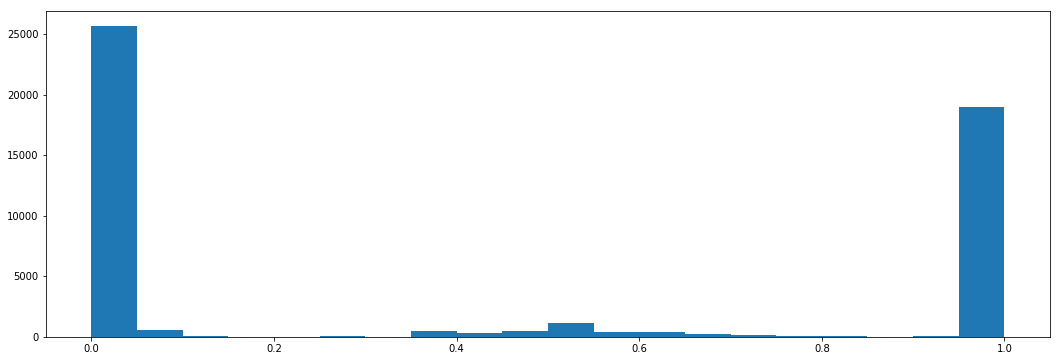

In [38]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [39]:
gen_model.weights.lf_accuracy()

array([ 0.84919398,  0.85076272,  0.8512645 ,  0.84879673,  0.85678602,
        0.8522265 ,  0.84884482,  0.84572541,  0.84858471,  0.88155879,
        0.88136689,  0.88148409,  0.88079708,  0.85104033,  0.88084884,
        0.88099645,  0.88078873,  0.81710897,  0.88397459,  0.88083456,
        0.88080624,  0.88080457,  0.8809833 ,  0.88079464,  0.88090051,
        0.87304286,  0.88060185,  0.88100632,  0.88115786,  0.85211594,
        0.88100551,  0.88096463,  0.8793934 ,  0.88078873,  0.88080461,
        0.88125193,  0.88112766,  0.88091281,  0.88082373,  0.83915282,
        0.88079875])

In [16]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 49042 training marginals


In [157]:
from snorkel.annotations import load_marginals
train_marginals = load_marginals(session, split=3)

### Using the Model to Iterate on Labeling Functions
Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set. First, we apply the LFs to our development set:

In [40]:
L_dev = labeler.apply_existing(split=4, parallelism=multiprocessing.cpu_count())

Clearing existing...
Running UDF...


In [41]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold_complex', split=4)

In [42]:
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.855
Neg. class accuracy: 0.634
Precision            0.445
Recall               0.855
F1                   0.585
----------------------------------------
TP: 572 | FP: 714 | TN: 1238 | FN: 97



In [43]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    fpsv = SentenceNgramViewer(fp, session, height=400)
else:
    fpsv = None

<IPython.core.display.Javascript object>

In [44]:
fpsv

In [45]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    fnsv = SentenceNgramViewer(fn, session, height=400)
else:
    fnsv = None

<IPython.core.display.Javascript object>

In [46]:
fnsv

In [47]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    tpsv = SentenceNgramViewer(tp, session, height=400)
else:
    tpsv = None

<IPython.core.display.Javascript object>

In [48]:
tpsv

In [49]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    tnsv = SentenceNgramViewer(tn, session, height=400)
else:
    tnsv = None

<IPython.core.display.Javascript object>

In [50]:
tnsv

At this point, we should be getting an F1 score of around 0.6 to 0.7 on the development set, which is pretty good! However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!
In fact, it is probably somewhat overfit to this set. However this is fine, since in the next tutorial, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a blind test set (i.e. one we never looked at during development).

## Doing Some Error Analysis

In [ ]:
At this point, we might want to look at some examples in one of the error buckets. For example, one of the false negatives that we did not correctly label as true mentions. To do this, we can again just use the Viewer:

In [22]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fp, session, height=400)
else:
    sv = None

<IPython.core.display.Javascript object>

In [45]:
sv

In [ ]:
from snorkel.lf_helpers import (
    get_left_tokens,
    get_between_tokens,
    get_right_tokens,
    contains_token,
    get_doc_candidate_spans,
    get_sent_candidate_spans,
    get_text_between,
    get_text_splits,
    get_tagged_text,
    is_inverted,
    get_tagged_text,
)
c = sv.get_selected() if sv else list(fp.union(fn))[0]
print(c)
print("\n")

c.labels
fp

## Automatically Creating Features

In [20]:
from snorkel.annotations import FeatureAnnotator
import multiprocessing
featurizer = FeatureAnnotator()

In [ ]:
%time F_train = featurizer.apply(split=3, parallelism=multiprocessing.cpu_count())
F_train

Clearing existing...
Running UDF...
CPU times: user 19min 8s, sys: 1min 7s, total: 20min 15s
Wall time: 1h 21min 33s


<49042x335440 sparse matrix of type '<type 'numpy.float64'>'
	with 2239396 stored elements in Compressed Sparse Row format>


Next, we apply the feature set we just got from the training set to the dev and test sets by using apply_existing:

In [38]:
%%time
F_dev  = featurizer.apply_existing(split=4, parallelism=multiprocessing.cpu_count())
F_test = featurizer.apply_existing(split=5, parallelism=multiprocessing.cpu_count())

Clearing existing...
Running UDF...
Clearing existing...
Running UDF...
CPU times: user 2min 47s, sys: 6.64 s, total: 2min 53s
Wall time: 7min 12s


In [21]:
F_train = featurizer.load_matrix(session, split=3)
F_dev   = featurizer.load_matrix(session, split=4)
F_test  = featurizer.load_matrix(session, split=5)

## Training the Discriminative Model

We use the training marginals to train a discriminative model that classifies each Candidate as a true or false mention. We'll use a random hyperparameter search, evaluated on the development set labels, to find the best hyperparameters for our model. To run a hyperparameter search, we need labels for a development set. If they aren't already available, we can manually create labels using the Viewer.

In [51]:
from snorkel.learning import SparseLogisticRegression
disc_model = SparseLogisticRegression()


Now we set up and run the hyperparameter search, training our model with different hyperparamters and picking the best model configuration to keep. We'll set the random seed to maintain reproducibility.
Note that we are fitting our model's parameters to the training set generated by our labeling functions, while we are picking hyperparamters with respect to score over the development set labels which we created by hand.

In [52]:
from snorkel.learning.utils import MentionScorer
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

# Searching over learning rate
rate_param = RangeParameter('lr', 1e-6, 1e-2, step=1, log_base=10)
l1_param  = RangeParameter('l1_penalty', 1e-6, 1e-2, step=1, log_base=10)
l2_param  = RangeParameter('l2_penalty', 1e-6, 1e-2, step=1, log_base=10)

searcher = RandomSearch(session, disc_model, F_train, train_marginals, [rate_param, l1_param, l2_param], n=20)

Initialized RandomSearch search of size 20. Search space size = 125.


Next, we'll load in our dev set labels. We will pick the optimal result from the hyperparameter search by testing against these labels:

In [53]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold_complex', split=4)

Finally, we run the hyperparameter search / train the end extraction model:

In [ ]:
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, n_epochs=50, rebalance=0.5, print_freq=25)

[1] Testing lr = 1.00e-02, l1_penalty = 1.00e-03, l2_penalty = 1.00e-04
[SparseLR] lr=0.01 l1=0.001 l2=0.0001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=42510  #epochs=50  batch size=100
[SparseLR] Epoch 0 (42.50s)	Avg. loss=0.341892	NNZ=335440
[SparseLR] Epoch 25 (1098.65s)	Avg. loss=0.214262	NNZ=335440
[SparseLR] Epoch 49 (2091.27s)	Avg. loss=0.212989	NNZ=335440
[SparseLR] Training done (2091.27s)
[SparseLR] Model saved. To load, use name
		SparseLR_0
[2] Testing lr = 1.00e-04, l1_penalty = 1.00e-06, l2_penalty = 1.00e-03
[SparseLR] lr=0.0001 l1=1e-06 l2=0.001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=42510  #epochs=50  batch size=100
[SparseLR] Epoch 0 (41.22s)	Avg. loss=0.690481	NNZ=335440
[SparseLR] Epoch 25 (1080.16s)	Avg. loss=0.220847	NNZ=335440
[SparseLR] Epoch 49 (2072.15s)	Avg. loss=0.150682	NNZ=335440
[SparseLR] Training done (2072.15s)
[SparseLR] Model saved. To load, use name
		SparseLR_1
[3] Testing lr = 1.00e-

[SparseLR] Training model
[SparseLR] #examples=42510  #epochs=50  batch size=100
[SparseLR] Epoch 0 (43.09s)	Avg. loss=2.942439	NNZ=335440
[SparseLR] Epoch 25 (1119.09s)	Avg. loss=0.311545	NNZ=335440
[SparseLR] Epoch 49 (2153.85s)	Avg. loss=0.255962	NNZ=335440
[SparseLR] Training done (2153.85s)
[16] Testing lr = 1.00e-05, l1_penalty = 1.00e-06, l2_penalty = 1.00e-04
[SparseLR] lr=1e-05 l1=1e-06 l2=0.0001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=42510  #epochs=50  batch size=100
[SparseLR] Epoch 0 (43.97s)	Avg. loss=0.748961	NNZ=335440
[SparseLR] Epoch 25 (1140.78s)	Avg. loss=0.493341	NNZ=335440
[SparseLR] Epoch 49 (2197.06s)	Avg. loss=0.409397	NNZ=335440
[SparseLR] Training done (2197.06s)
[17] Testing lr = 1.00e-06, l1_penalty = 1.00e-02, l2_penalty = 1.00e-03
[SparseLR] lr=1e-06 l1=0.01 l2=0.001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=42510  #epochs=50  batch size=100
[SparseLR] Epoch 0 (43.71s)	Avg. loss=3.443486	NNZ=

,lr,l1_penalty,l2_penalty,Prec.,Rec.,F1
13,0.001000,0.000010,0.000100,0.462205,0.877429,0.605467
19,0.010000,0.000010,0.000100,0.464058,0.868460,0.604893
7,0.010000,0.000010,0.010000,0.462580,0.868460,0.603636
1,0.000100,0.000001,0.001000,0.461234,0.871450,0.603207
11,0.001000,0.000001,0.001000,0.461173,0.869955,0.602796
2,0.001000,0.000010,0.000010,0.460205,0.872945,0.602683
3,0.001000,0.000001,0.001000,0.460380,0.868460,0.601761
17,0.010000,0.000010,0.000001,0.458464,0.874439,0.601542
8,0.000100,0.010000,0.000001,0.460863,0.862481,0.600729
0,0.010000,0.001000,0.000100,0.457389,0.874439,0.600616


In [25]:
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, n_epochs=50, rebalance=0.5, print_freq=25)

[1] Testing lr = 1.00e-02, l1_penalty = 1.00e-03, l2_penalty = 1.00e-04
[SparseLR] lr=0.01 l1=0.001 l2=0.0001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=32744  #epochs=50  batch size=100
[SparseLR] Epoch 0 (30.48s)	Avg. loss=0.432813	NNZ=335440
[SparseLR] Epoch 25 (790.38s)	Avg. loss=0.298315	NNZ=335440
[SparseLR] Epoch 49 (1517.56s)	Avg. loss=0.297865	NNZ=335440
[SparseLR] Training done (1517.56s)
[SparseLR] Model saved. To load, use name
		SparseLR_0
[2] Testing lr = 1.00e-04, l1_penalty = 1.00e-06, l2_penalty = 1.00e-03
[SparseLR] lr=0.0001 l1=1e-06 l2=0.001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=32744  #epochs=50  batch size=100
[SparseLR] Epoch 0 (30.21s)	Avg. loss=0.709220	NNZ=335440
[SparseLR] Epoch 25 (784.99s)	Avg. loss=0.319969	NNZ=335440
[SparseLR] Epoch 49 (1511.30s)	Avg. loss=0.256312	NNZ=335440
[SparseLR] Training done (1511.30s)
[SparseLR] Model saved. To load, use name
		SparseLR_1
[3] Testing lr = 1.00e-03

[SparseLR] Epoch 0 (33.10s)	Avg. loss=3.012970	NNZ=335440
[SparseLR] Epoch 25 (852.33s)	Avg. loss=0.409730	NNZ=335440
[SparseLR] Epoch 49 (1635.75s)	Avg. loss=0.364573	NNZ=335440
[SparseLR] Training done (1635.75s)
[16] Testing lr = 1.00e-05, l1_penalty = 1.00e-06, l2_penalty = 1.00e-04
[SparseLR] lr=1e-05 l1=1e-06 l2=0.0001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=32744  #epochs=50  batch size=100
[SparseLR] Epoch 0 (32.69s)	Avg. loss=0.714633	NNZ=335440
[SparseLR] Epoch 25 (860.11s)	Avg. loss=0.548152	NNZ=335440
[SparseLR] Epoch 49 (1688.72s)	Avg. loss=0.483729	NNZ=335440
[SparseLR] Training done (1688.72s)
[17] Testing lr = 1.00e-06, l1_penalty = 1.00e-02, l2_penalty = 1.00e-03
[SparseLR] lr=1e-06 l1=0.01 l2=0.001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=32744  #epochs=50  batch size=100
[SparseLR] Epoch 0 (34.77s)	Avg. loss=3.417448	NNZ=335440
[SparseLR] Epoch 25 (895.27s)	Avg. loss=3.265608	NNZ=335440
[SparseLR] Epoch

,lr,l1_penalty,l2_penalty,Prec.,Rec.,F1
1,0.000100,0.000001,0.001000,0.478299,0.807175,0.600667
8,0.000100,0.010000,0.000001,0.484171,0.777280,0.596672
7,0.010000,0.000010,0.010000,0.478694,0.789238,0.595937
12,0.000100,0.000100,0.000010,0.474622,0.796712,0.594866
13,0.001000,0.000010,0.000100,0.476148,0.790732,0.594382
11,0.001000,0.000001,0.001000,0.476407,0.784753,0.592885
2,0.001000,0.000010,0.000010,0.472792,0.792227,0.592179
10,0.000100,0.010000,0.000100,0.479516,0.769806,0.590935
14,0.000100,0.010000,0.000010,0.479070,0.769806,0.590596
3,0.001000,0.000001,0.001000,0.473351,0.783259,0.590090


In [ ]:
np.random.seed(1701)
searcher.fit(F_dev, L_gold_dev, n_epochs=50, rebalance=0.5, print_freq=25)

[1] Testing lr = 1.00e-02, l1_penalty = 1.00e-03, l2_penalty = 1.00e-04
[SparseLR] lr=0.01 l1=0.001 l2=0.0001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=42128  #epochs=50  batch size=100
[SparseLR] Epoch 0 (44.73s)	Avg. loss=0.360985	NNZ=335440
[SparseLR] Epoch 25 (1157.84s)	Avg. loss=0.226158	NNZ=335440
[SparseLR] Epoch 49 (2225.73s)	Avg. loss=0.224808	NNZ=335440
[SparseLR] Training done (2225.73s)
[SparseLR] Model saved. To load, use name
		SparseLR_0
[2] Testing lr = 1.00e-04, l1_penalty = 1.00e-06, l2_penalty = 1.00e-03
[SparseLR] lr=0.0001 l1=1e-06 l2=0.001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=42128  #epochs=50  batch size=100
[SparseLR] Epoch 0 (46.66s)	Avg. loss=0.663224	NNZ=335440
[SparseLR] Epoch 25 (1154.08s)	Avg. loss=0.230863	NNZ=335440



Note that to train a model without tuning any hyperparameters (at your own risk) just use the train method of the discriminative model. For instance, to train with 20 epochs and a learning rate of 0.001, you could run:
disc_model.train(F_train, train_marginals, n_epochs=20, lr=0.001)
We can analyze the learned model by examining the weights. For example, we can print out the features with the highest weights.

In [171]:
disc_model.train(F_train, train_marginals, n_epochs=50, lr=0.001, batch_size=100, \
                 l1_penalty=0.00001, l2_penalty=0.0001, print_freq=25,\
                 rebalance=0.5, seed=1701)

[SparseLR] lr=0.001 l1=1e-05 l2=0.0001
[SparseLR] Building model
[SparseLR] Training model
[SparseLR] #examples=42510  #epochs=50  batch size=100
[SparseLR] Epoch 0 (47.29s)	Avg. loss=0.720581	NNZ=335440
[SparseLR] Epoch 25 (1176.88s)	Avg. loss=0.289488	NNZ=335440
[SparseLR] Epoch 49 (2273.70s)	Avg. loss=0.238248	NNZ=335440
[SparseLR] Training done (2273.70s)


In [26]:
w, _ = disc_model.get_weights()
largest_idxs = reversed(np.argsort(np.abs(w))[-5:])
for i in largest_idxs:
    print 'Feature: {0: <70}Weight: {1:.6f}'.format(F_train.get_key(session, i).name, w[i])

Feature: TDL_LEMMA:SEQ-BETWEEN[protein]                                        Weight: -0.765179
Feature: TDL_SEQ-BETWEEN[LEN:5-7]                                              Weight: -0.749731
Feature: TDL_LEMMA:LEFT-OF-MENTION[plant]                                      Weight: 0.675402
Feature: TDL_LEMMA:SEQ-BETWEEN[-lrb-]                                          Weight: -0.674927
Feature: TDL_INV_LEMMA:SEQ-BETWEEN[the]                                        Weight: -0.631184



In this last section of the tutorial, we'll get the score we've been after: the performance of the extraction model on the blind test set (split 2). First, we load the test set labels and gold candidates we made in Part III.

In [27]:
from snorkel.annotations import load_gold_labels
L_gold_test = load_gold_labels(session, annotator_name='gold_complex', split=5)

In [163]:
disc_model.model

AttributeError: 'SparseLogisticRegression' object has no attribute 'model'

Now, we score using the discriminative model:

In [28]:
_, _, _, _ = disc_model.score(session, F_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.807
Neg. class accuracy: 0.698
Precision            0.478
Recall               0.807
F1                   0.601
----------------------------------------
TP: 540 | FP: 589 | TN: 1363 | FN: 129



In [29]:
_, _, _, _ = disc_model.score(session, F_test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.802
Neg. class accuracy: 0.665
Precision            0.531
Recall               0.802
F1                   0.639
----------------------------------------
TP: 562 | FP: 496 | TN: 986 | FN: 139




Note that if this is the final test set that you will be reporting final numbers on, to avoid biasing results you should not inspect results. However you can run the model on your development set and, as we did in the previous part with the generative labeling function model, inspect examples to do error analysis.